In [1]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

In [2]:
data = load_boston()
#波士顿数据集非常简单，但它所涉及到的问题却很多
X = data.data
y = data.target

print('all:',X.shape,'--->',y.shape)

all: (506, 13) ---> (506,)


In [3]:
Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.3,random_state=420)
print('train:',Xtrain.shape,'--->',Ytrain.shape)
print('test:',Xtest.shape,'--->',Ytest.shape)

reg = XGBR(n_estimators=100).fit(Xtrain,Ytrain)
reg.predict(Xtest) #传统接口predict
score = reg.score(Xtest,Ytest) #你能想出这里应该返回什么模型评估指标么？
print('score:',score)
mse = MSE(Ytest,reg.predict(Xtest))
print('MSE:', mse)
reg.feature_importances_ #树模型的优势之一：能够查看模型的重要性分数，可以使用嵌入法进行特征选择

train: (354, 13) ---> (354,)
test: (152, 13) ---> (152,)
score: 0.9050988954757183
MSE: 8.830916470718748


array([0.01902167, 0.0042109 , 0.01478317, 0.00553536, 0.02222195,
       0.37914094, 0.01679687, 0.04698721, 0.04073574, 0.05491758,
       0.0668422 , 0.00869463, 0.32011184], dtype=float32)

In [10]:
reg = XGBR(n_estimators=100)
cvs1 = CVS(reg,Xtrain,Ytrain,cv=10).mean() 
#这里应该返回什么模型评估指标，还记得么？
#严谨的交叉验证与不严谨的交叉验证之间的讨论：训练集or全数据？
cvs2 = CVS(reg,Xtrain,Ytrain,cv=10,scoring='neg_mean_squared_error').mean()
print('XBGR:',cvs1,'=====',cvs2)

#来查看一下sklearn中所有的模型评估指标
import sklearn
sorted(sklearn.metrics.SCORERS.keys())
#使用随机森林和线性回归进行一个对比
rfr = RFR(n_estimators=100)
cvs1 = CVS(rfr,Xtrain,Ytrain,cv=50).mean()
cvs2 = CVS(rfr,Xtrain,Ytrain,cv=50,scoring='neg_mean_squared_error').mean()
print('RFR:',cvs1,'=====',cvs2)

lr = LinearR()
cvs1 = CVS(lr,Xtrain,Ytrain,cv=5).mean()
cvs2 = CVS(lr,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()
print('LinearR:',cvs1,'=====',cvs2)

#如果开启参数slient：在数据巨大，预料到算法运行会非常缓慢的时候可以使用这个参数来监控模型的训练进度
# params = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'reg:linear'}
reg = XGBR(n_estimators=100)
XGBR_cvs1 = CVS(reg,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()
print('XGBR_slient:',XGBR_cvs1)

XBGR: 0.7883239859105383 ===== -17.657931994400368
RFR: 0.72778293910584 ===== -12.749524998928571
LinearR: 0.6835070597278078 ===== -25.3495074936485
XGBR_slient: -16.215644658473447


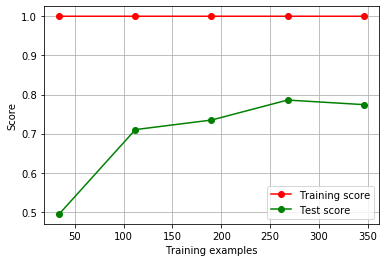

In [22]:
def plot_learning_curve(estimator,title, X, y,
    ax=None, #选择子图
    ylim=None, #设置纵坐标的取值范围
    cv=None, #交叉验证
    n_jobs=None #设定索要使用的线程
    ):
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
    ,shuffle=True
    ,cv=cv
    # ,random_state=420
    ,n_jobs=n_jobs)
    
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
        ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
        
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须

    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
    , color="r",label="Training score") 
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
    , color="g",label="Test score")
    ax.legend(loc="best")
    
    return ax

cv = KFold(n_splits=50, shuffle = True, random_state=42)
plot_learning_curve(XGBR(n_estimators=100,random_state=420),"XGB",Xtrain,Ytrain,ax=None,cv=cv)

plt.show()
#多次运行，观察结果，这是怎么造成的？
#在现在的状况下，如何看数据的潜力？还能调上去么？

100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517 0.03353715574288529


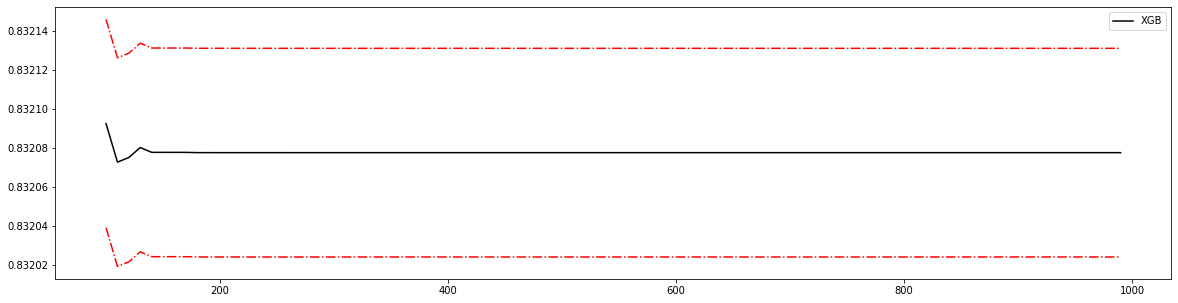

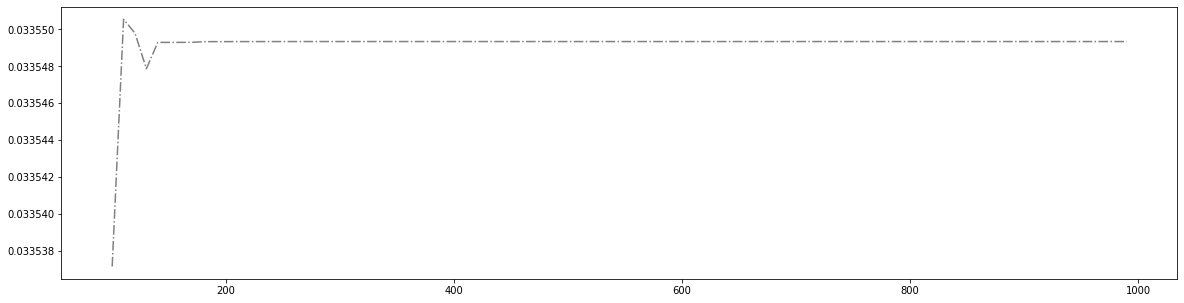

In [16]:
axisx = range(100,300,10)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
#添加方差线
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()
#看看泛化误差的可控部分如何？
plt.figure(figsize=(20,5))
plt.plot(axisx,ge,c="gray",linestyle='-.')
plt.show()

In [7]:
#验证模型效果是否提高了？
time0 = time()
print(XGBR(n_estimators=100,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)
time0 = time()
print(XGBR(n_estimators=660,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)
time0 = time()
print(XGBR(n_estimators=180,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)

0.9050988954757183
0.05585074424743652
0.9050526024842831
0.0937492847442627
0.9050526024842831
0.18851447105407715
